# Continued

In [1]:
import pandas as pd
import json
json_data = open('../views/sample/input00.in') # Edit this to where you have put the input00.in file

data = []
for line in json_data:
    data.append(json.loads(line))

data.remove(9000)
data.remove(1000)

df = pd.DataFrame(data)
cleaned_df=pd.DataFrame(data[0:9000])
data_df = cleaned_df.copy()

In [2]:
# extra libraries
from plotnine import *

/usr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# More Text Analysis

In [4]:
# The 75th and 90th percentile of the `__ans__` column.
data_df['__ans__'].quantile([0.75, 0.9])

0.75     4.019578
0.90    12.787143
Name: __ans__, dtype: float64

Let's analyze the frequency of words that show up in question texts that have `__ans__` in the 75th or above percentile

In [3]:
# svf stands for seventy-fifth
svf_words = data_df[data_df.__ans__ >= 4.019578][['question_text']].question_text.values
svf_words = ' '.join(svf_words).split()
svf_unique_words = sorted(set(svf_words))

In [4]:
svf_list = [] 
for word in svf_unique_words:
    if len(word) >= 3:
        a = [int(svf_words.count(word)), str(word)]
        svf_list.append(a)

svf_list_df = pd.DataFrame(svf_list, columns=['freq', 'word']).sort_values(by=['freq'], ascending=False)
svf_list_df.describe()

,freq
count,7615.000000
mean,3.025476
std,21.722844
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,1275.000000


Since it's an intensive task to create a correlation on each of the 7615 words, most of which only appear once anyway, let's instead just work with the most frequent 1,000 words. 

In [5]:
# first sort the whole thing
svf_list_df = pd.DataFrame(svf_list, columns=['freq', 'word']).sort_values(by=['freq'], ascending=False)

# pick out the most frequent 1000 words
svf_words_freq_sorted = svf_list_df['word'][:1000].sample(frac=1) # the `sample` method randomizes all the rows (frac=1) after picking the top 1000

In [6]:
# convert in to an array
svf_list_ = svf_words_freq_sorted.values 
svf_list_

array(['more', 'less', 'learned', 'according', 'because', 'true', 'view',
       'international', 'able', 'death?', 'sports', 'cannot', 'better',
       'currently', 'sites', 'happen', 'during', 'things', 'language?',
       'add', 'college', 'least', 'hotel', 'embedded', 'mind', 'sources',
       'long', 'smart', 'start?', 'chance', 'Microsoft', 'level',
       'universities', 'companies', 'move', 'just', 'ability', 'was',
       'fall', 'become', "can't", 'text', 'oil', 'differences', 'process',
       'political', 'into', 'startups', 'list', 'country?', 'food',
       'download', 'them?', 'space', 'decision?', 'Windows', 'successful',
       'exist?', 'experience', 'grow', 'difficult', 'virtual', 'choose',
       'necessary', 'economy?', 'said', 'english', 'growth', 'scope',
       'across?', 'machine?', 'finance', 'low', 'history?', 'make',
       'and/or', 'why?', 'possible', 'regular', 'coding', 'names', 'write',
       'access', 'among', 'leading', 'consulting', 'period', 'each'

To make our task even less intensive (running the analysis, which I will describe below, took longer than 15 mins on the 1000 words), let's do it in chunks. Details below. 

In [7]:
# divide svf_list_ into chunks
out = []
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    last = 0.0
    
    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

In [8]:
# the array `out` has 20 subarrays containing 50 words
chunkIt(svf_list_, 20)

We will run each word and look up the correlation.

In [9]:
# give it an index and it will return the correlation array of the words in `out[index]`
def corrIt(idx):
    var = []
    for i in range(len(out[idx])):
        a = data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(str(out[idx][i]))) else 0)
        var.append(a.corr(data_df['__ans__']))
    return var

In [10]:
# return a sorted dataframe with words and their correlation in appearance
def dfIt(idx):
    corr_list = corrIt(idx)
    mash_df = pd.concat([pd.DataFrame(corr_list, columns=['cor']),pd.DataFrame(out[idx],
                                                                       columns=['word'])],
                   axis=1)
    return mash_df.sort_values(by='cor', ascending=False)

In [11]:
df_19=dfIt(19)
df_19.head()

,cor,word
15,0.034105,With
6,0.028274,world?
48,0.024004,would
38,0.021665,have
44,0.011307,significance


Would be nice to add the length and frequency.

In [12]:
def enrich(data_f):
    data_f['len'] = data_f['word'].apply(lambda x: len(x)) #adds length
    data_f['freq'] = data_f['word'].apply(lambda x: # grab frequency of the word from `svf_list_df`
                                          svf_list_df[svf_list_df['word']==x].iloc[0].freq)
    return data_f

In [13]:
enrich(df_19).head()

,cor,word,len,freq
15,0.034105,With,4,4
6,0.028274,world?,6,17
48,0.024004,would,5,128
38,0.021665,have,4,171
44,0.011307,significance,12,5


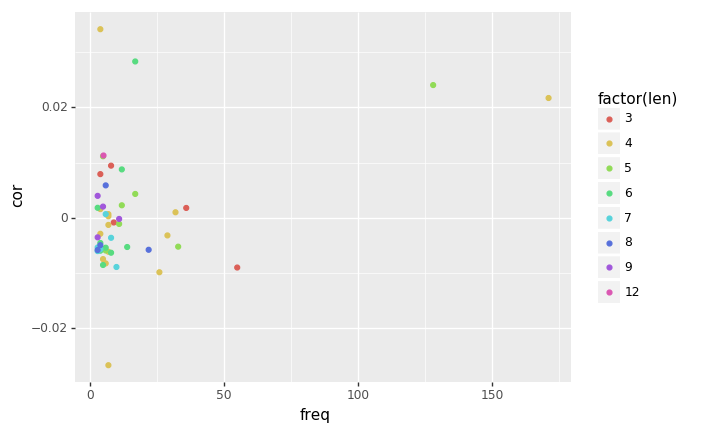

<ggplot: (-9223363274697024831)>

In [14]:
(ggplot(df_19, aes('freq', 'cor', color='factor(len)'))+ geom_point())

In [15]:
df_19['len'].value_counts(bins=4)

(2.99, 5.25]    26
(5.25, 7.5]     15
(7.5, 9.75]      8
(9.75, 12.0]     1
Name: len, dtype: int64

In [16]:
# divide length into bins
bins = [2.9, 4.9, 7.9, 12] # bins will be effectively be [3, 5) etc
group_names = ['[3, 5)', '[5-8)', '[8-12]']
df_19['len_bins'] = pd.cut(df_19.len, bins, labels=group_names)

In [17]:
df_19.head()

,cor,word,len,freq,len_bins
15,0.034105,With,4,4,"[3, 5)"
6,0.028274,world?,6,17,[5-8)
48,0.024004,would,5,128,[5-8)
38,0.021665,have,4,171,"[3, 5)"
44,0.011307,significance,12,5,[8-12]


Now let's redo the plot.

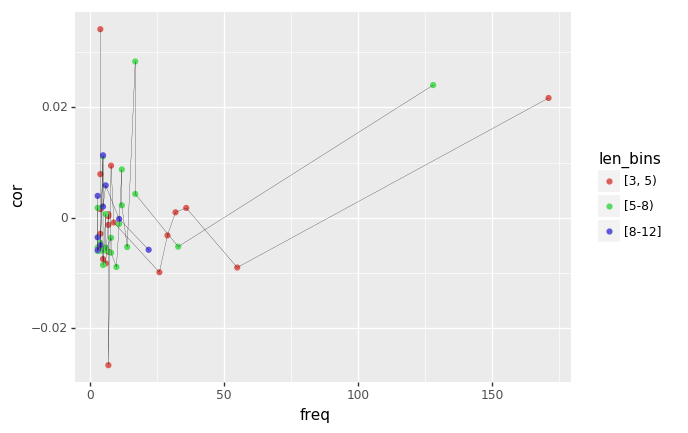

<ggplot: (-9223363274697119274)>

In [18]:
(ggplot(df_19, aes('freq', 'cor'))
     + geom_point(aes(color='len_bins'))
     + geom_line(aes(group='len_bins'), size=0.1)
)

We could use zooming into 0-50 freq as it is apparent that higher frequency words have higher correlation. 

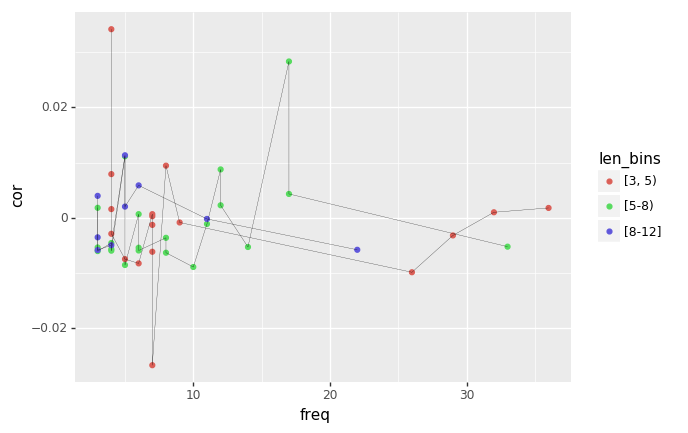

<ggplot: (8762157645772)>

In [19]:

(ggplot(df_19[df_19['freq']<50], aes('freq', 'cor'))
     + geom_point(aes(color='len_bins'))
     + geom_line(aes(group='len_bins'), size=0.1)
)

So the previous conclusion hold for words that are three or four letters long.

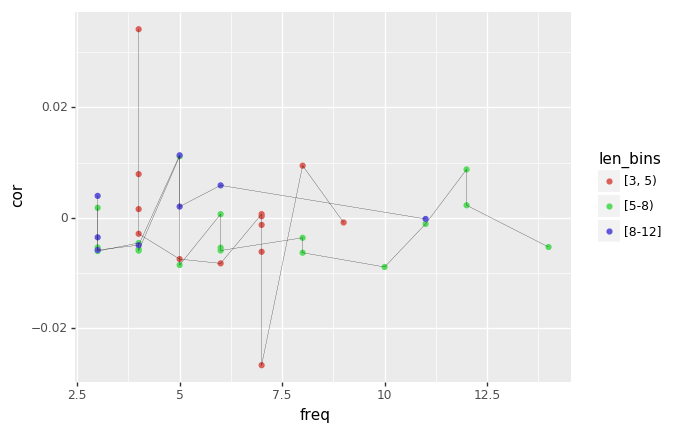

<ggplot: (8762157580215)>

In [20]:

(ggplot(df_19[df_19['freq']<15], aes('freq', 'cor'))
     + geom_point(aes(color='len_bins'))
     + geom_line(aes(group='len_bins'), size=0.1)
)

Nothing more is descernable at this point.

---

To check our work, let's go through the code. Say, we pick `out[19][2]`, the second word in the 19th slice 

In [21]:
print(out[19][2], str(out[19][2]))
data_df.question_text.apply(lambda x: 1 if any(pd.Series(x).str.contains(str(out[19][2]))) else 0).describe()

Has Has


count    9000.000000
mean        0.006000
std         0.077231
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: question_text, dtype: float64

The series has 9000 entries of zeroes and one--zero means the question text in that row doesn't contain the keyword `out[19][2]=`*research*. So, looking at the mean of the series, we can tell data points with a question text conatining this word are 0.6% of the dataset. 

On the other hand, we are calculating the correlation between `__ans__` and the above series of 0's and 1's. This effectively tells us if we should weigh question texts with the particular word more.  

Now, we will check the correlation in the remaining 19 chunks as we did with the 19th chunk. Simply run `corrIt(index)`. 

In [35]:
# Searching for `\\` it only appears once as `\\sin` and `++` only appears in `C++`
for i in range(20):
    try:
        if list(out[i]).index('\\sin') != 999:
            print('\\sin is at', i, list(out[i]).index('\\sin'))
        if list(out[i]).index('C++') != 999:
            print('C++ is at ', i, list(out[i]).index('C++'))
    except:
        pass

\sin is at 3 7


In [36]:
out[3][7]

'\\sin'

We need to get rid of this to avoid [`multiple repeat` errors](https://docs.python.org/2/library/re.html).

In [37]:
out[3][7] = 'sin'

### Calculate the correlation of all the lists

In [ ]:
corr_big_list = []
for i in range(0,20):
    corr_big_list.append(corrIt(i))

In [2]:
print('\n')
print('Min')
for i in range(len(corr_big_list)):
    print(i, min(corr_big_list[i]))
print('\n')
print('Max')
for i in range(len(corr_big_list)):
    print( i, max(corr_big_list[i]))



Min


NameError: name 'corr_big_list' is not defined

In [ ]:
corr_big_list[4].index(0.1023288271726879)

In [1]:
corr_big_list

NameError: name 'corr_big_list' is not defined

In [ ]:
out[4][15]

Ok *university* does really well compared to others, with correlation of `0.10`. What if we look at the combination of the top 3 words.